# Norris vs Piastri - Hungarian GP 2025 Analysis

In [39]:
import fastf1 as ff1
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

ff1.Cache.enable_cache('../data')

session = ff1.get_session(2025, "Hungary", "R")
session.load()

drivers = ["NOR", "PIA"]
laps = session.laps.pick_drivers(drivers)

core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '63', '16', '14', '5', '18', '30', '1', '12', '6', '44', '27', '55', '23', '31', '22', '43', '10', '87']


## 1. Data Extraction and Feature Engineering

In [40]:
def extract_telemetry_features(laps, driver):
    features_list = []
    driver_laps = laps.pick_drivers(driver).pick_quicklaps()
    
    for lap in driver_laps.iterlaps():
        lap_num, lap_data = lap
        
        try:
            car_data = lap_data.get_car_data().add_distance()
            
            features = {
                "Driver": driver,
                "LapNumber": lap_num,
                "LapTime": lap_data["LapTime"].total_seconds(),
                "Compound": lap_data["Compound"],
                "TyreLife": lap_data["TyreLife"],
                "FreshTyre": lap_data["FreshTyre"],
                "Sector1Time": lap_data["Sector1Time"].total_seconds() if pd.notna(lap_data["Sector1Time"]) else np.nan,
                "Sector2Time": lap_data["Sector2Time"].total_seconds() if pd.notna(lap_data["Sector2Time"]) else np.nan,
                "Sector3Time": lap_data["Sector3Time"].total_seconds() if pd.notna(lap_data["Sector3Time"]) else np.nan,
            }
            
            features["AvgSpeed"] = car_data["Speed"].mean()
            features["MaxSpeed"] = car_data["Speed"].max()
            features["MinSpeed"] = car_data["Speed"].min()
            features["SpeedStd"] = car_data["Speed"].std()
            features["Speed95Percentile"] = car_data["Speed"].quantile(0.95)
            
            brake_zones = car_data["Brake"] > 0
            features["BrakeTime"] = brake_zones.sum() / len(car_data)
            features["BrakingEvents"] = ((brake_zones.astype(int).diff()).eq(1)).sum()
            features["MaxBrakePressure"] = car_data["Brake"].max()
            features["AvgBrakePressure"] = car_data[car_data["Brake"] > 0]["Brake"].mean() if any(brake_zones) else 0
            
            features["FullThrottleRatio"] = (car_data["Throttle"] > 95).sum() / len(car_data)
            features["PartialThrottleRatio"] = ((car_data["Throttle"] > 20) & (car_data["Throttle"] < 95)).sum() / len(car_data)
            features["CoastingRatio"] = (car_data["Throttle"] < 20).sum() / len(car_data)
            features["ThrottleVariance"] = car_data["Throttle"].var()
            
            features["SteeringActivity"] = car_data["nGear"].diff().abs().sum()
            features["AvgRPM"] = car_data["RPM"].mean()
            features["MaxRPM"] = car_data["RPM"].max()
            
            features["SpeedEfficiency"] = features["AvgSpeed"] / features["FullThrottleRatio"] if features["FullThrottleRatio"] > 0 else 0
            
            if not pd.isna(features["Sector1Time"]) and not pd.isna(features["Sector2Time"]) and not pd.isna(features["Sector3Time"]):
                sector_times = [features["Sector1Time"], features["Sector2Time"], features["Sector3Time"]]
                features["SectorConsistency"] = np.std(sector_times) / np.mean(sector_times)
            else:
                features["SectorConsistency"] = np.nan
            
            features_list.append(features)
            
        except Exception as e:
            print(f"Error processing lap {lap_num} for {driver}: {e}")
            continue
    
    return pd.DataFrame(features_list)

In [41]:
df_nor = extract_telemetry_features(laps, "NOR")
df_pia = extract_telemetry_features(laps, "PIA")
df_combined = pd.concat([df_nor, df_pia], ignore_index=True)
df_combined = df_combined.dropna(subset=['LapTime'])

## 2. Stint Detection and Strategy Analysis

In [42]:
def detect_stint_changes(df, driver):
    driver_data = df[df['Driver'] == driver].copy()
    driver_data = driver_data.sort_values('LapNumber')
    
    driver_data['StintNumber'] = 0
    current_compound = None
    current_tyre_life = None
    stint_number = 0
    
    for idx, (_, lap) in enumerate(driver_data.iterrows()):
        lap_compound = lap['Compound']
        lap_tyre_life = lap['TyreLife']
        
        if (current_compound != lap_compound) or \
           (current_tyre_life is not None and lap_tyre_life < current_tyre_life):
            stint_number += 1
        
        driver_data.loc[driver_data.index[idx], 'StintNumber'] = stint_number
        current_compound = lap_compound
        current_tyre_life = lap_tyre_life
    
    return driver_data

df_with_stints = pd.DataFrame()
for driver in drivers:
    driver_with_stints = detect_stint_changes(df_combined, driver)
    df_with_stints = pd.concat([df_with_stints, driver_with_stints], ignore_index=True)

## 3. Performance Analysis Visualization

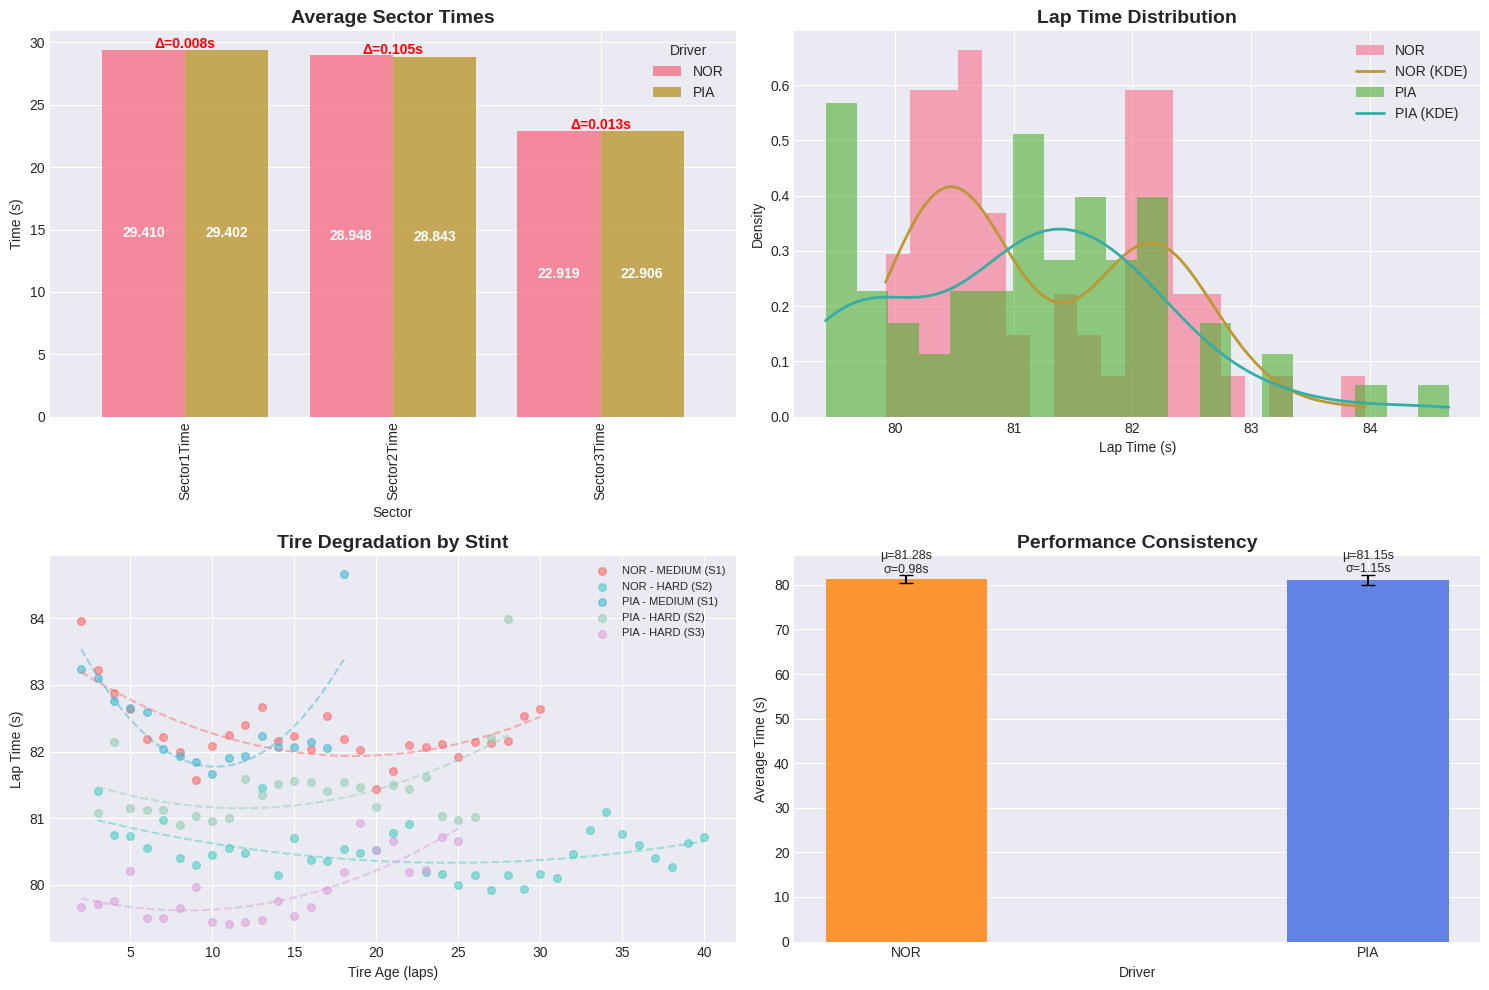

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sector Times Comparison
sector_cols = ["Sector1Time", "Sector2Time", "Sector3Time"]
sector_means = df_combined.groupby("Driver")[sector_cols].mean()

ax = axes[0, 0]
sector_means.T.plot(kind="bar", ax=ax, width=0.8, alpha=0.8)
ax.set_title("Average Sector Times", fontsize=14, fontweight='bold')
ax.set_ylabel("Time (s)")
ax.set_xlabel("Sector")
ax.legend(title="Driver")

for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type="center", color="white", fontsize=10, fontweight="bold")

for i, sector in enumerate(sector_cols):
    delta = sector_means.loc["NOR", sector] - sector_means.loc["PIA", sector]
    color = "green" if delta < 0 else "red"
    ax.text(i, sector_means[sector].max() * 1.005, f"Δ={delta:.3f}s", ha='center', fontsize=10, fontweight='bold', color=color)

# Lap Time Distribution
ax = axes[0, 1]
for driver in drivers:
    driver_data = df_combined[df_combined["Driver"] == driver]["LapTime"]
    ax.hist(driver_data, alpha=0.6, label=driver, bins=20, density=True)
    
    density = stats.gaussian_kde(driver_data)
    xs = np.linspace(driver_data.min(), driver_data.max(), 100)
    ax.plot(xs, density(xs), linewidth=2, label=f'{driver} (KDE)')

ax.set_xlabel("Lap Time (s)")
ax.set_ylabel("Density")
ax.set_title("Lap Time Distribution", fontsize=14, fontweight='bold')
ax.legend()

# Tire Degradation by Stint
ax = axes[1, 0]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#DDA0DD', '#98D8C8', '#F8C471']
color_idx = 0

for driver in drivers:
    driver_data = df_with_stints[df_with_stints['Driver'] == driver]
    
    for stint_num in sorted(driver_data['StintNumber'].unique()):
        stint_data = driver_data[driver_data['StintNumber'] == stint_num]
        
        if len(stint_data) > 0:
            compound = stint_data['Compound'].iloc[0]
            color = colors[color_idx % len(colors)]
            
            ax.scatter(stint_data["TyreLife"], stint_data["LapTime"],
                      label=f"{driver} - {compound} (S{stint_num})", alpha=0.6, s=30, color=color)
            
            if len(stint_data) > 3:
                x_vals = stint_data['TyreLife'].values
                y_vals = stint_data['LapTime'].values
                
                if len(set(x_vals)) > 1:
                    z = np.polyfit(x_vals, y_vals, 2)
                    p = np.poly1d(z)
                    x_line = np.linspace(x_vals.min(), x_vals.max(), 100)
                    ax.plot(x_line, p(x_line), "--", alpha=0.5, color=color)
            
            color_idx += 1

ax.set_xlabel("Tire Age (laps)")
ax.set_ylabel("Lap Time (s)")
ax.set_title("Tire Degradation by Stint", fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=8)

# Consistency Analysis
ax = axes[1, 1]
consistency_metrics = df_combined.groupby("Driver").agg({"LapTime": ["mean", "std", "min", "max"]})

drivers_list = consistency_metrics.index.tolist()
x = np.arange(len(drivers_list))
width = 0.35

mean_times = consistency_metrics["LapTime"]["mean"].values
std_times = consistency_metrics["LapTime"]["std"].values

bars = ax.bar(x, mean_times, width, yerr=std_times, capsize=5, color=['#FF8000', '#4169E1'], alpha=0.8)
ax.set_ylabel("Average Time (s)")
ax.set_xlabel("Driver")
ax.set_title("Performance Consistency", fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(drivers_list)

for i, (bar, mean, std) in enumerate(zip(bars, mean_times, std_times)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.5,
            f'μ={mean:.2f}s\nσ={std:.2f}s', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## 3. Optimal Lap Potential Calculation

In [44]:
def calculate_theoretical_best(driver_data):
    best_s1 = driver_data['Sector1Time'].min()
    best_s2 = driver_data['Sector2Time'].min()
    best_s3 = driver_data['Sector3Time'].min()
    
    if pd.notna(best_s1) and pd.notna(best_s2) and pd.notna(best_s3):
        return best_s1 + best_s2 + best_s3
    return None

theoretical_best = {}
for driver in drivers:
    driver_data = df_combined[df_combined['Driver'] == driver]
    theoretical_best[driver] = calculate_theoretical_best(driver_data)
    
    if theoretical_best[driver]:
        actual_best = driver_data['LapTime'].min()
        print(f"\n{driver}:")
        print(f"  Best actual lap: {actual_best:.3f}s")
        print(f"  Theoretical best: {theoretical_best[driver]:.3f}s")
        print(f"  Potential improvement: {actual_best - theoretical_best[driver]:.3f}s")


NOR:
  Best actual lap: 79.918s
  Theoretical best: 79.721s
  Potential improvement: 0.197s

PIA:
  Best actual lap: 79.412s
  Theoretical best: 78.770s
  Potential improvement: 0.642s


## 4. Driving Style Clustering Analysis

Optimal number of clusters: 3


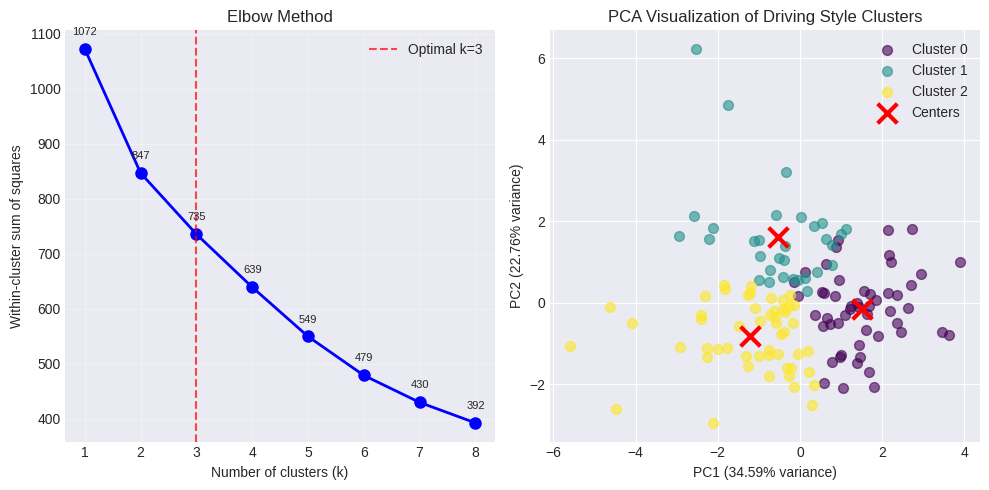


Cluster distribution by driver (%):
Cluster   0.0   1.0   2.0
Driver                   
NOR      43.3  17.9  38.8
PIA      34.3  28.4  37.3

Average cluster characteristics:
         BrakeTime  BrakingEvents  FullThrottleRatio  PartialThrottleRatio  \
Cluster                                                                      
0.0          0.217         11.865              0.479                 0.211   
1.0          0.230         11.194              0.444                 0.236   
2.0          0.231         11.098              0.441                 0.222   

         SpeedStd  ThrottleVariance  SpeedEfficiency  SectorConsistency  \
Cluster                                                                   
0.0        57.351          1907.730          405.192              0.109   
1.0        58.639          1900.085          432.591              0.105   
2.0        55.634          1957.882          433.793              0.112   

         LapTime  
Cluster           
0.0       80.779  
1

In [45]:
clustering_features = [
    "BrakeTime", "BrakingEvents", "FullThrottleRatio", 
    "PartialThrottleRatio", "SpeedStd", "ThrottleVariance",
    "SpeedEfficiency", "SectorConsistency"
]

X_cluster = df_combined[clustering_features].dropna()
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

# Elbow Method for Optimal Clusters
inertias = []
K_range = range(1, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)

def find_elbow_point(inertias, k_range):
    n_points = len(inertias)
    x_line = np.linspace(0, n_points-1, n_points)
    y_line = np.linspace(inertias[0], inertias[-1], n_points)
    
    distances = []
    for i in range(n_points):
        x_point, y_point = i, inertias[i]
        distance = abs((y_line[-1] - y_line[0]) * x_point - (x_line[-1] - x_line[0]) * y_point + 
                      x_line[-1] * y_line[0] - y_line[-1] * x_line[0]) / \
                  np.sqrt((y_line[-1] - y_line[0])**2 + (x_line[-1] - x_line[0])**2)
        distances.append(distance)
    
    elbow_idx = np.argmax(distances)
    return k_range[elbow_idx]

optimal_k = find_elbow_point(inertias, K_range)

# Clustering Visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow Method')
plt.grid(True, alpha=0.3)
plt.legend()

for i, (k, inertia) in enumerate(zip(K_range, inertias)):
    plt.annotate(f'{inertia:.0f}', (k, inertia), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=8)

print(f"Optimal number of clusters: {optimal_k}")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)
df_combined.loc[X_cluster.index, 'Cluster'] = cluster_labels

# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

plt.subplot(1, 2, 2)
colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    mask = cluster_labels == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colors[i]], label=f'Cluster {i}', alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA Visualization of Driving Style Clusters')

centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centers')

plt.legend()
plt.tight_layout()
plt.show()

cluster_analysis = pd.crosstab(
    df_combined.loc[X_cluster.index, "Driver"],
    df_combined.loc[X_cluster.index, "Cluster"],
    normalize='index'
) * 100

print("\nCluster distribution by driver (%):")
print(cluster_analysis.round(1))

print("\nAverage cluster characteristics:")
cluster_profiles = df_combined.groupby('Cluster')[clustering_features + ['LapTime']].mean()
print(cluster_profiles.round(3))

## 5. Monte Carlo Strategy Simulation

In [46]:
def extract_strategy_from_stints(df_with_stints, driver):
    driver_data = df_with_stints[df_with_stints['Driver'] == driver]
    strategy = []
    
    for stint_num in sorted(driver_data['StintNumber'].unique()):
        stint_data = driver_data[driver_data['StintNumber'] == stint_num]
        compound = stint_data['Compound'].iloc[0]
        length = len(stint_data)
        strategy.append((compound, length))
    
    return strategy

def calculate_actual_performance(df, driver):
    driver_data = df[df['Driver'] == driver]
    return {
        'total_time': driver_data['LapTime'].sum(),
        'num_laps': len(driver_data),
        'avg_laptime': driver_data['LapTime'].mean()
    }

def build_degradation_model(df, driver):
    driver_data = df[df['Driver'] == driver]
    model = {}
    
    for compound in driver_data['Compound'].unique():
        if pd.notna(compound):
            compound_data = driver_data[driver_data['Compound'] == compound]
            
            if len(compound_data) > 2:
                x = compound_data['TyreLife'].values
                y = compound_data['LapTime'].values
                
                if len(x) > 1 and len(set(x)) > 1:
                    coef = np.polyfit(x, y, 1)
                    degradation = coef[0]
                else:
                    degradation = 0.02
                
                model[compound] = {
                    'mean': compound_data['LapTime'].mean(),
                    'std': max(compound_data['LapTime'].std(), 0.1),
                    'degradation': degradation
                }
    
    return model

def simulate_strategy_comparison(driver_model, own_strategy, other_strategy):
    n_simulations = 1000
    differences = []
    
    for _ in range(n_simulations):
        time_own = 0
        time_other = 0
        
        min_laps = min(sum(length for _, length in own_strategy),
                      sum(length for _, length in other_strategy))
        
        current_lap = 0
        
        for compound, stint_length in own_strategy:
            if current_lap >= min_laps:
                break
            if compound in driver_model:
                for lap_in_stint in range(min(stint_length, min_laps - current_lap)):
                    base_time = driver_model[compound]['mean']
                    degradation = driver_model[compound]['degradation'] * lap_in_stint
                    noise = np.random.normal(0, driver_model[compound]['std'] * 0.5)
                    time_own += base_time + degradation + noise
                    current_lap += 1
        
        current_lap = 0
        
        for compound, stint_length in other_strategy:
            if current_lap >= min_laps:
                break
            if compound in driver_model:
                for lap_in_stint in range(min(stint_length, min_laps - current_lap)):
                    base_time = driver_model[compound]['mean']
                    degradation = driver_model[compound]['degradation'] * lap_in_stint
                    noise = np.random.normal(0, driver_model[compound]['std'] * 0.5)
                    time_other += base_time + degradation + noise
                    current_lap += 1
        
        differences.append(time_other - time_own)
    
    return np.array(differences)

# Strategy Analysis Output
print("=" * 60)
print("STRATEGY ANALYSIS - COMPARATIVE ASSESSMENT")
print("=" * 60)

actual_strategies = {}
actual_performances = {}

for driver in drivers:
    strategy = extract_strategy_from_stints(df_with_stints, driver)
    performance = calculate_actual_performance(df_combined, driver)
    actual_strategies[driver] = strategy
    actual_performances[driver] = performance
    
    print(f"\n{driver} - Race Performance:")
    print(f"   Laps analyzed: {performance['num_laps']}")
    print(f"   Total time: {performance['total_time']:.1f}s")
    print(f"   Average lap: {performance['avg_laptime']:.3f}s")
    
    print(f"   Strategy:")
    for i, (compound, length) in enumerate(strategy, 1):
        percentage = (length / performance['num_laps']) * 100
        print(f"     Stint {i}: {compound:<7} - {length:2d} laps ({percentage:4.1f}%)")

degradation_models = {}
for driver in drivers:
    degradation_models[driver] = build_degradation_model(df_combined, driver)

print(f"\n{'=' * 50}")
print("STRATEGY EFFECTIVENESS SIMULATION")
print("=" * 50)

strategy_differences = {}

for driver in drivers:
    other_driver = "PIA" if driver == "NOR" else "NOR"
    own_strategy = actual_strategies[driver]
    other_strategy = actual_strategies[other_driver]
    
    valid = all(compound in degradation_models[driver] for compound, _ in other_strategy)
    
    if valid:
        differences = simulate_strategy_comparison(
            degradation_models[driver], 
            own_strategy, 
            other_strategy
        )
        strategy_differences[driver] = differences
        
        mean_diff = np.mean(differences)
        std_diff = np.std(differences)
        
        print(f"\n{driver} with {other_driver}'s strategy:")
        if mean_diff > 0:
            print(f"   Would lose {mean_diff:.1f}s (±{std_diff:.1f}s)")
        elif mean_diff < 0:
            print(f"   Would gain {abs(mean_diff):.1f}s (±{std_diff:.1f}s)")
        else:
            print(f"   Negligible difference")

STRATEGY ANALYSIS - COMPARATIVE ASSESSMENT

NOR - Race Performance:
   Laps analyzed: 67
   Total time: 5445.6s
   Average lap: 81.277s
   Strategy:
     Stint 1: MEDIUM  - 29 laps (43.3%)
     Stint 2: HARD    - 38 laps (56.7%)

PIA - Race Performance:
   Laps analyzed: 67
   Total time: 5437.1s
   Average lap: 81.151s
   Strategy:
     Stint 1: MEDIUM  - 17 laps (25.4%)
     Stint 2: HARD    - 26 laps (38.8%)
     Stint 3: HARD    - 24 laps (35.8%)

STRATEGY EFFECTIVENESS SIMULATION

NOR with PIA's strategy:
   Would gain 14.1s (±2.3s)

PIA with NOR's strategy:
   Would lose 22.3s (±5.1s)


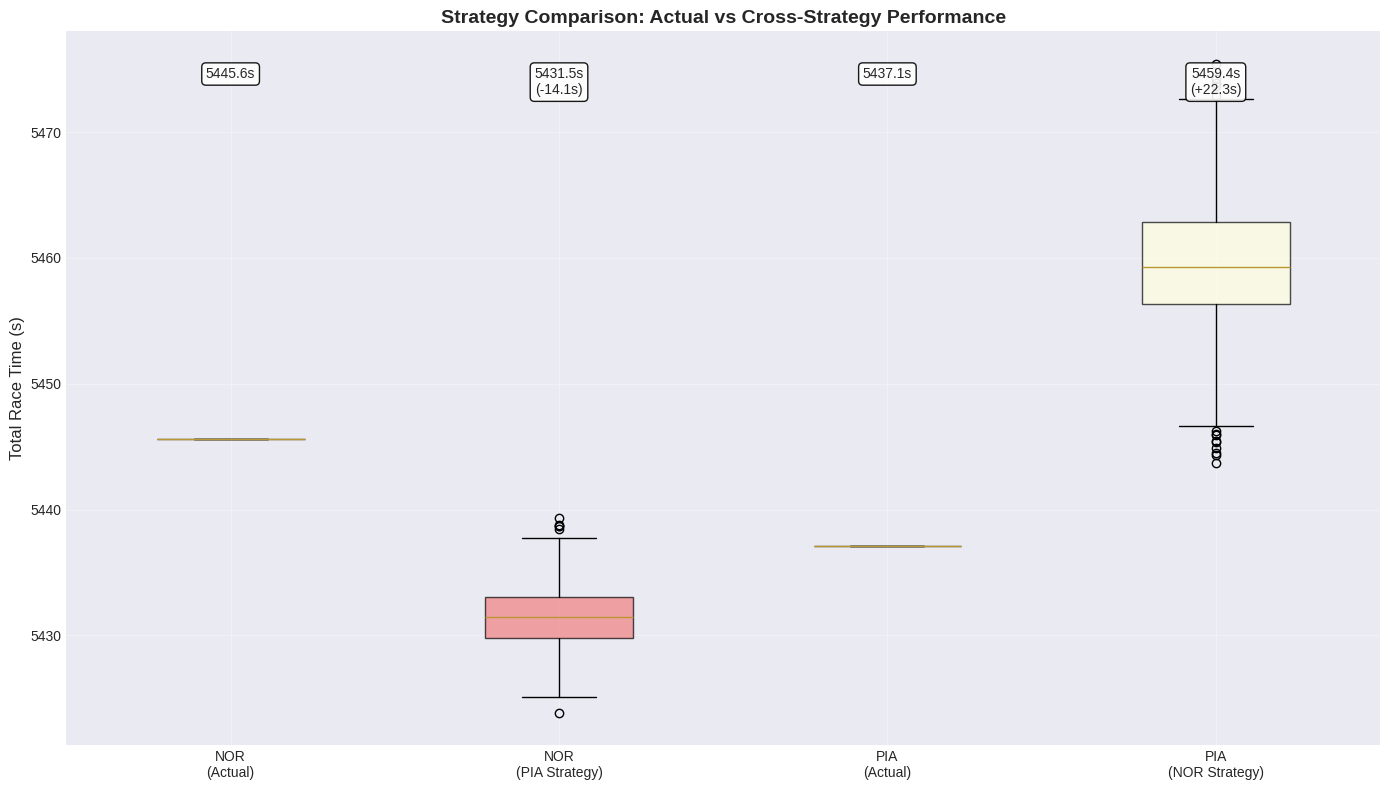

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

plot_data = []
plot_labels = []
colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']

plot_order = [
    ("NOR", "actual"),
    ("NOR", "cross"),
    ("PIA", "actual"),
    ("PIA", "cross")
]

for driver, mode in plot_order:
    if mode == "actual":
        total_time = actual_performances[driver]['total_time']
        plot_data.append([total_time] * 100)
        plot_labels.append(f'{driver}\n(Actual)')
    else:
        if driver in strategy_differences:
            other_driver = "PIA" if driver == "NOR" else "NOR"
            differences = strategy_differences[driver]
            adjusted_totals = actual_performances[driver]['total_time'] + differences
            plot_data.append(adjusted_totals)
            plot_labels.append(f'{driver}\n({other_driver} Strategy)')

bp = ax.boxplot(plot_data, tick_labels=plot_labels, patch_artist=True)

for i, (patch, color) in enumerate(zip(bp['boxes'], colors)):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Total Race Time (s)', fontsize=12)
ax.set_title('Strategy Comparison: Actual vs Cross-Strategy Performance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

y_min, y_max = ax.get_ylim()
text_height = y_max - (y_max - y_min) * 0.05

for i, data in enumerate(plot_data):
    mean_val = np.mean(data)
    
    if "Strategy)" in plot_labels[i]:
        driver = plot_labels[i].split("\n")[0]
        actual_idx = plot_labels.index(f"{driver}\n(Actual)")
        actual_mean = np.mean(plot_data[actual_idx])
        diff = mean_val - actual_mean
        diff_text = f"\n({diff:+.1f}s)" if abs(diff) > 0.5 else ""
    else:
        diff_text = ""

    ax.text(i + 1, text_height, f'{mean_val:.1f}s{diff_text}', ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

## 6. Strategic Recommendations and Summary

In [48]:
print("\n" + "=" * 60)
print("STRATEGIC RECOMMENDATIONS")
print("=" * 60)

print("\n### DRIVING STYLE ASSESSMENT ###")

nor_stints = len(actual_strategies['NOR'])
pia_stints = len(actual_strategies['PIA'])

print(f"NOR: {nor_stints} stints | PIA: {pia_stints} stints")

if abs(nor_stints - pia_stints) > 1:
    if nor_stints > pia_stints:
        print("- NOR: Aggressive multi-stop approach")
        print("- PIA: Conservative long-stint strategy")
    else:
        print("- PIA: Aggressive multi-stop approach")  
        print("- NOR: Conservative long-stint strategy")
else:
    print("- Similar strategic philosophies")


print("\n### SECTOR PERFORMANCE ###")

print("\nSector comparison:")
for i in range(1, 4):
    sector = f'Sector{i}Time'
    if sector in df_combined.columns:
        nor_avg = df_combined[df_combined['Driver'] == 'NOR'][sector].mean()
        pia_avg = df_combined[df_combined['Driver'] == 'PIA'][sector].mean()
        diff = nor_avg - pia_avg
        
        if abs(diff) > 0.01:
            faster = "NOR" if diff < 0 else "PIA"
            print(f"  Sector {i}: {faster} faster by {abs(diff):.3f}s")
        else:
            print(f"  Sector {i}: Even performance")

print(f"\nDevelopment priorities:")
for driver in drivers:
    other = "PIA" if driver == "NOR" else "NOR"
    
    gaps = {}
    for i in range(1, 4):
        sector = f'Sector{i}Time'
        if sector in df_combined.columns:
            driver_avg = df_combined[df_combined['Driver'] == driver][sector].mean()
            other_avg = df_combined[df_combined['Driver'] == other][sector].mean()
            gaps[f'Sector {i}'] = driver_avg - other_avg
    
    if gaps:
        worst = max(gaps.items(), key=lambda x: x[1])
        best = min(gaps.items(), key=lambda x: x[1])
        
        print(f"  {driver}:")
        if best[1] < 0:
            print(f"    - Strength: {best[0]} ({best[1]:.3f}s advantage)")
        else:
            print(f"    - Strength: {best[0]} (minimal deficit: {best[1]:.3f}s)")
        
        if worst[1] > 0:
            print(f"    - Focus area: {worst[0]} ({worst[1]:.3f}s deficit)")


print("\n### STRATEGY EFFECTIVENESS ###")

for driver in drivers:
    if driver in strategy_differences:
        other = "PIA" if driver == "NOR" else "NOR"
        diff_mean = np.mean(strategy_differences[driver])
        
        print(f"\n{driver} strategy assessment:")
        if abs(diff_mean) < 1:
            print(f"  Strategy was optimal (negligible difference)")
        elif diff_mean > 0:
            print(f"  Strategy was superior (+{diff_mean:.1f}s advantage)")
        else:
            print(f"  Could improve with {other}'s approach ({diff_mean:.1f}s potential gain)")


print("\n### TIRE MANAGEMENT ###")

for driver in drivers:
    if driver in degradation_models:
        print(f"\n{driver} tire performance:")
        
        degradation_rates = {}
        for compound, model in degradation_models[driver].items():
            if 'degradation' in model:
                degradation_rates[compound] = model['degradation']
        
        if len(degradation_rates) > 1:
            best_compound = min(degradation_rates.items(), key=lambda x: x[1])
            worst_compound = max(degradation_rates.items(), key=lambda x: x[1])
            
            print(f"  Best preservation: {best_compound[0]} ({best_compound[1]:+.4f}s/lap)")
            print(f"  Highest degradation: {worst_compound[0]} ({worst_compound[1]:+.4f}s/lap)")
        
        avg_degradation = np.mean(list(degradation_rates.values())) if degradation_rates else 0
        if avg_degradation < 0.02:
            print(f"  Assessment: Excellent tire preservation")
        elif avg_degradation < 0.04:
            print(f"  Assessment: Good tire management")
        else:
            print(f"  Assessment: High degradation - aggressive approach")

print(f"\nComparative tire management:")
if 'NOR' in degradation_models and 'PIA' in degradation_models:
    nor_avg_deg = np.mean([model['degradation'] for model in degradation_models['NOR'].values()])
    pia_avg_deg = np.mean([model['degradation'] for model in degradation_models['PIA'].values()])
    
    if abs(nor_avg_deg - pia_avg_deg) > 0.01:
        better_manager = "NOR" if nor_avg_deg < pia_avg_deg else "PIA"
        worse_manager = "PIA" if nor_avg_deg < pia_avg_deg else "NOR"
        diff = abs(nor_avg_deg - pia_avg_deg)
        
        print(f"  {better_manager}: Superior tire preservation ({diff:.3f}s/lap advantage)")
        print(f"  {worse_manager}: More aggressive, higher degradation")
        
        if better_manager == "NOR" and nor_stints < pia_stints:
            print(f"  Analysis: NOR's better tire management enabled fewer stops")
        elif better_manager == "PIA" and pia_stints > nor_stints:
            print(f"  Analysis: Despite more stops, PIA shows good tire preservation")
    else:
        print(f"  Similar tire management approaches between drivers")


print("\n### CONSISTENCY ANALYSIS ###")

for driver in drivers:
    driver_data = df_combined[df_combined['Driver'] == driver]
    std_laptime = driver_data['LapTime'].std()
    
    print(f"\n{driver} consistency:")
    print(f"  Lap time standard deviation: {std_laptime:.3f}s")
    
    if std_laptime < 1.0:
        print(f"  Assessment: Excellent consistency")
        print("  Recommendation: Maintain current approach, focus on raw pace")
    elif std_laptime < 2.0:
        print(f"  Assessment: Good consistency")
        print("  Recommendation: Minor improvements in stint management possible")
    else:
        print(f"  Assessment: Consistency needs improvement")
        print("  Recommendation: Focus on managing variable conditions")


print("\n### STRATEGIC SYNTHESIS ###")

best_overall = min(actual_performances.items(), key=lambda x: x[1]['avg_laptime'])
print(f"\nBest overall performance: {best_overall[0]}")
print(f"Average lap time: {best_overall[1]['avg_laptime']:.3f}s")

print(f"\nKey findings:")

# Strategy validation
optimal_count = 0
for driver in drivers:
    if driver in strategy_differences:
        diff_mean = np.mean(strategy_differences[driver])
        if diff_mean >= 0:  # Current strategy was as good or better
            optimal_count += 1

total_drivers = len([d for d in drivers if d in strategy_differences])

if total_drivers > 0:
    if optimal_count == total_drivers:
        validation_status = "Both drivers used optimal strategies"
    elif optimal_count == 0:
        validation_status = "Both drivers could improve their strategy choices"
    else:
        validation_status = "Mixed - one driver's strategy was optimal, the other could improve"
    
    print(f"  - Strategy validation: {validation_status}")

# Determine who had better tire management
if 'NOR' in degradation_models and 'PIA' in degradation_models:
    nor_deg = np.mean([model['degradation'] for model in degradation_models['NOR'].values()])
    pia_deg = np.mean([model['degradation'] for model in degradation_models['PIA'].values()])
    better_tires = "NOR" if nor_deg < pia_deg else "PIA"
    print(f"  - Tire management advantage: {better_tires}")

# Strategic approach
if abs(nor_stints - pia_stints) > 1:
    approach_description = "Very different strategic philosophies"
elif abs(nor_stints - pia_stints) == 1:
    approach_description = "Different strategic approaches"
else:
    approach_description = "Similar strategic approaches"

print(f"  - Strategic approach: {approach_description}")

print(f"\nRecommendations for future races:")
print(f"  1. Maintain identified strengths in sector performance")
print(f"  2. Address weaker sectors through targeted practice")
print(f"  3. Consider tire management lessons from better performer")
print(f"  4. Improve consistency where standard deviation > 1.5s")
print(f"  5. Validate strategy choices through continued simulation")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE")
print("=" * 60)


STRATEGIC RECOMMENDATIONS

### DRIVING STYLE ASSESSMENT ###
NOR: 2 stints | PIA: 3 stints
- Similar strategic philosophies

### SECTOR PERFORMANCE ###

Sector comparison:
  Sector 1: Even performance
  Sector 2: PIA faster by 0.105s
  Sector 3: PIA faster by 0.013s

Development priorities:
  NOR:
    - Strength: Sector 1 (minimal deficit: 0.008s)
    - Focus area: Sector 2 (0.105s deficit)
  PIA:
    - Strength: Sector 2 (-0.105s advantage)

### STRATEGY EFFECTIVENESS ###

NOR strategy assessment:
  Could improve with PIA's approach (-14.1s potential gain)

PIA strategy assessment:
  Strategy was superior (+22.3s advantage)

### TIRE MANAGEMENT ###

NOR tire performance:
  Best preservation: MEDIUM (-0.0239s/lap)
  Highest degradation: HARD (-0.0084s/lap)
  Assessment: Excellent tire preservation

PIA tire performance:
  Best preservation: MEDIUM (-0.0098s/lap)
  Highest degradation: HARD (+0.0506s/lap)
  Assessment: Good tire management

Comparative tire management:
  NOR: Superior t